# MLSS2019: Bayesian Deep Learning

In this tutorial we will learn what basic building blocks are needed
to endow (deep) neural networks with uncertainty estimates, and how
this can be used in active learning or expert-in-the-loop pipelines.

The plan of the tutorial
1. [Setup and imports](#Setup-and-imports)
2. [Easy uncertainty in networks](#Easy-uncertainty-in-networks)
   1. [Adding stochasticity](#Adding-stochasticity)
   2. [Implementing function sampling with the DropoutLinear Layer](#Implementing-function-sampling-with-the-DropoutLinear-Layer)
   3. [Comparing sample functions to point-estimates](#Comparing-sample-functions-to-point-estimates)
3. [A brief reminder on Bayesian and Variational Inference](#A-brief-reminder-on-Bayesian-and-Variational-Inference)
4. [Bayesian Active Learning with images](#Bayesian-Active-Learning-with-images)
   1. [the Acquisition Function](#the-Acquisition-Function)
   2. [Dropout $2$-d Convolutional layer and the model](#Dropout-$2$-d-Convolutional-layer-and-the-model)
   3. [Actively learning MNIST](#Actively-Learning-MNIST)

<br>

## Setup and imports

In this section we import necessary modules and functions and
define the computational device.

First, we install some boilerplate service code for this tutorial.

In [ ]:
!pip install --upgrade git+https://github.com/mlss-skoltech/tutorials.git#subdirectory=bayesian_deep_learning

Next, numpy for computing, matplotlib for plotting and tqdm for progress bars.

In [2]:
import tqdm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

For deep learning stuff will be using [pytorch](https://pytorch.org/).

If you are unfamiliar with it, it is basically like `numpy` with autograd,
native GPU support, and tools for building training and serializing models.
<!-- (and with `axis` argument replaced with `dim` :) -->

There are good introductory tutorials on `pytorch`, like this
[one](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html).

In [3]:
import torch
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Linear, Conv2d

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We will need some functionality from scikit

In [4]:
from sklearn.metrics import confusion_matrix

Next we import the boilerplate code.

* a procedure that implements a minibatch SGD **fit** loop
* a function, that **evaluates** the model on the provided dataset

In [5]:
from mlss2019bdl import fit, apply

```python
def fit(model, dataset, criterion, ...):
    # pseudocode
    for epoch in epochs:
        for batch in dataset:
            loss = criterion(model, batch)  # forward pass

            grad = loss.backward()          # gradient via back propagation

            adam_step(grad)
```

<br>

## Easy uncertainty in networks

Suppose we have the following model: a 3-layer fully connected
network with LeakyReLU activations.

In [6]:
model = torch.nn.Sequential(
    Linear(1, 512, bias=True),
    torch.nn.LeakyReLU(),

    Linear(512, 512, bias=True),
    torch.nn.LeakyReLU(),

    Linear(512, 1, bias=True),
)

Generate the initial small dataset $S_0 = (x_i, y_i)_{i=1}^{m_0}$
with $y_i = g(x_i)$, $x_i$ on a regular-spaced grid, and $
g
    \colon \mathbb{R} \to \mathbb{R}
    \colon x \mapsto \tfrac{x^2}4 + \sin \frac\pi2 x
$.
<!--
`dataset_from_numpy` **converts** numpy arrays into torch tensors,
**places** them on the specified compute device, **and packages**
into a dataset
-->

In [7]:
from mlss2019bdl import dataset_from_numpy

X_train = np.linspace(-6.0, +6.0, num=20)[:, np.newaxis]
y_train = np.sin(X_train * np.pi / 2) + 0.25 * X_train**2

train = dataset_from_numpy(X_train, y_train, device=device)

Let's fit our model on `train` using MSE loss and $\ell_2$ penalty
on weights (`weight_decay`):
$$
    \tfrac1{2 m} \|f_\omega(x) - y\|_2^2 + \lambda \|\omega\|_2^2
    \,, $$
where $\omega$ are all the learnable parameters of the model $f_\omega(\cdot)$.

In [8]:
model.to(device)

fit(model, train, criterion="mse", n_epochs=2000, verbose=True, weight_decay=1e-4)

100%|██████████| 2000/2000 [00:04<00:00, 435.21it/s]


Sequential(
  (0): Linear(in_features=1, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=512, out_features=512, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=512, out_features=1, bias=True)
)

..., compute the predictions, ...

In [9]:
X_domain = np.linspace(-10., +10., num=251)[:, np.newaxis]

domain = dataset_from_numpy(X_domain, device=device)

y_pred = apply(model, domain)

..., and plot them.

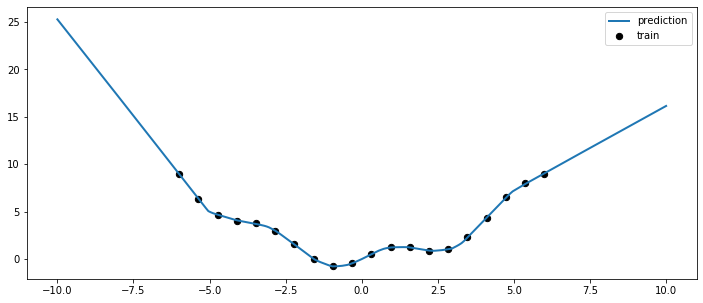

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.scatter(X_train, y_train, c="black", s=40, label="train")

ax.plot(X_domain, y_pred.numpy(), c="C0", lw=2, label="prediction")

plt.legend();

This model seems to fit the train set adequately well. However, there is no
way to assess how confident this model is with respect to its predictions.
Indeed, the prediction $\hat{y}_x = f_\omega(x)$ is is a deterministic function
of the input $x$ and the learnt parameters $\omega$.

<br>

### Adding stochasticity

One inexpensive way to make any network into a stochastic function of its
input is to add dropout before any parameterized layer like `linear`
or `convolutional`, [Hinton et al. 2012](https://arxiv.org/abs/1207.0580).
Essentially, dropout applies a Bernoulli mask to the features of the input.

For example, on the inputs into a linear layer it acts like this: for input
$
    x\in \mathbb{R}^{[\mathrm{in}]}
$ and layer weights $
    W\in \mathbb{R}^{[\mathrm{out}] \times [\mathrm{in}]}
$
and bias $
    b\in \mathbb{R}^{[\mathrm{out}]}
$ the resulting effect is

$$
    \tilde{x} = x \odot m
    \,, \\
    y = \tilde{x} W^\top + b
%     = b + \sum_i x_i m_i W_i
    \,, $$

where $\odot$ is the elementwise product and $m\in \mathbb{R}^{[\mathrm{in}]}$
with $m_j \sim \pi_p(m_j) = \mathcal{Ber}\bigl(\bigl\{0, \tfrac1{1-p}\bigr\}, 1-p\bigr)$,
i.e. equals $\tfrac1{1-p}$ with probability $1-p$ and $0$ otherwise.

In [Gal, Y. (2016)](http://www.cs.ox.ac.uk/people/yarin.gal/website/thesis/thesis.pdf)
it has been shown that a simple, somewhat ad-hoc approach, of
adding uncertainty quantification to networks through dropout,
[Hinton et al. 2012](https://arxiv.org/abs/1207.0580),
is a special case of Variational Inference.

```
A simple stochastic regularization method allows uncertainty estimation essentially for free!
```

#### (task) Always Active Dropout

`pytorch` has a function for this `F.dropout(input, p, training)`. It multiplies
each element of the `input` tensor by an independent Bernoulli rv. The argument
`p` has the same meanin as above. The boolean argument `training` toggles the
effect: if `False` then the input is returned as-is, otherwise the mask is applied.

In [11]:
class ActiveDropout(torch.nn.Dropout):
    # There is no need to redefine __init__(...), since
    #  we are directly inheriting from `Dropout`.

    def forward(self, input):
        """We need to permanently latch the `training` toggle
        to `True` in order to enable stochastic forward pass in
        evaluation mode (`model.eval()`).
        """

        ## Exercise: self.p - contains the specified dropout rate

        pass

<br>

#### (task) Rebuilding the model

Let's recreate the model above with this freshly minted dropout layer.
Then fit and plot it's prediction uncertainty due to forward pass stochasticity.

In [12]:
def build_model(p=0.5):
    """Build a model with dropout layers' rate set to `p`."""

    return torch.nn.Sequential(
        ## Exercise: Use ActiveDropout before the linear layers of
        #  our first network. Note that dropping out input features
        #  is not a good idea!

    )

<br>

In [13]:
model = build_model(p=0.5)
model.to(device)

fit(model, train, criterion="mse", n_epochs=2000, verbose=True, weight_decay=1e-5)

100%|██████████| 2000/2000 [00:04<00:00, 430.81it/s]


Sequential(
  (0): Linear(in_features=1, out_features=512, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): ActiveDropout(p=0.5)
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): ActiveDropout(p=0.5)
  (6): Linear(in_features=512, out_features=1, bias=True)
)

<br>

#### (task) Sampling the random output

Let's take the test sample $\tilde{S} = (\tilde{x}_i)_{i=1}^m \in \mathcal{X}$
and repeat the stochastic forward pass $B$ times at each $x\in \tilde{S}$:

* for $b = 1 .. B$ do:

  1. draw $y_{bi} \sim f_\omega(\tilde{x}_i)$ for $i = 1 .. m$.

In [14]:
def point_estimate(model, dataset, n_samples=1, verbose=False):
    """Draw pointwise samples with stochastic forward pass."""

    ## Exercise: collect the random predictions over the dataset
    ##  in a list, and then stack them into a `n_samples` x m x d tensor,
    ##  where d is the dimension of the prediction output, `m` -- the size of the dataset.

    outputs = []
    # apply the model to the dataset

    return # srack on the zero-th dim

    pass


samples = point_estimate(model, domain, n_samples=101, verbose=True)
samples.shape

100%|██████████| 101/101 [00:00<00:00, 529.58it/s]


torch.Size([101, 251, 1])

```python
samples.shape  # should be 101 x 251 x 1
```

<br>

The approximate $95\%$ confidence band of predictions is

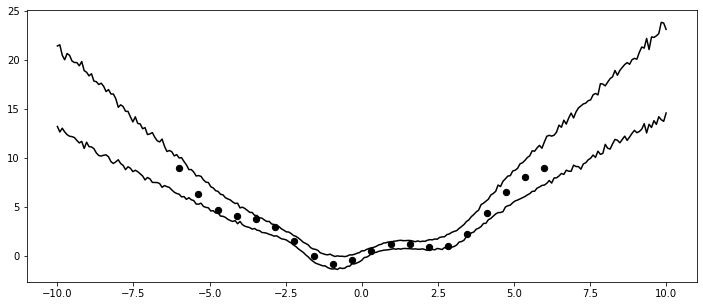

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.scatter(X_train, y_train, c="black", s=40, label="train")

mean, std = samples.mean(dim=0).numpy(), samples.std(dim=0).numpy()
ax.plot(X_domain, mean + 1.96 * std, c="k")
ax.plot(X_domain, mean - 1.96 * std, c="k");

Let's inspect the draws $y_{bi}$ as $B$ functional samples:
$(x_i, y_{bi})_{i=1}^m$ - the $b$-th sample path.

Below we plot $5$ random paths.

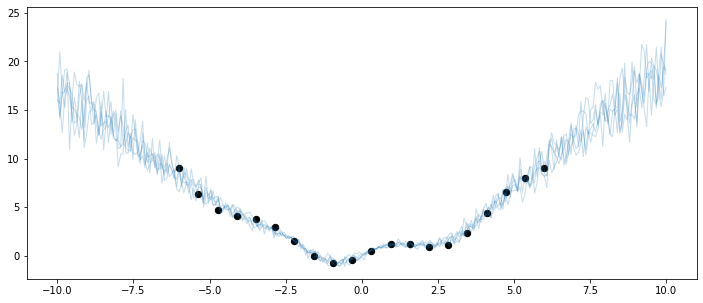

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.scatter(X_train, y_train, c="black", s=40, label="train")
ax.plot(X_domain[:, 0], samples[:5, :, 0].numpy().T, c="C0", lw=1, alpha=0.25);

It is clear that they are very erratic!

Computing stochastic forward passes with a new mask each time is equivalent
to drawing new **independent** prediction from for each point $x\in \tilde{S}$,
without considering that, in fact, at adjacent points the predictions should
be correlated.

For example, is we were interested in uncertainty at some particular point,
this would be okay: **fast and simple**. In contrast, if we were interested in
the uncertainty of an integral **path-dependent** measure of the whole estimated
function, or were doing **optimization** of the unknown true function taking
estimation uncertainty into account, then this clearly erratic behaviour
of paths is undesirable.
Ex. see [blog: Gal, Y. 2016](http://www.cs.ox.ac.uk/people/yarin.gal/website/blog_2248.html)

#### Question(s) (to ponder in your spare time)

* what will happen if you change the default dropout rate in `ActiveDropout` layer?
  Try to rebuild the model with different $p \in (0, 1)$ using `build_model(p)`,
  and then plot the predictive bands.

In [17]:
pass

<br>

### Implementing function sampling with the DropoutLinear Layer

The naive implementation of `ActiveDropout` above defines the predictive
distribution $y\sim p(y \mid x)$ as $y=f_\omega(x; m)$ for $m \sim \pi_p(m)$,
where $\pi(m)$ denotes the distribution of Bernoulli dropout masks
$\mathcal{Ber}\bigl(\bigl\{0, \tfrac1{1-p}\bigr\}, 1-p\bigr)$.

We will implement two things: merge the `ActiveDropout` and `Linear` layers
into `DropoutLinear`, and create a model class that can construct itself
with the specified base layer, e.g. `Linear` instead of `DropoutLinear`.
This would enable drawing realizations from the induced distribution over
functions defined by the network $
\bigl\{
    f_\omega\colon \mathcal{X}\to\mathcal{Y}
\bigr\}_{\omega \sim q(\omega)}
$
where $q(\omega)$ a distribution over the network parameters.

#### model class

In [18]:
class SimpleModel(torch.nn.Module):
    def __init__(self, layer, **kwargs):
        """Construct a simple network with the specified `layer`."""

        assert issubclass(layer, torch.nn.Linear)
        super().__init__()

        # the first layer in always deterministic
        self.fc1 = Linear(1, 512, bias=True)

        self.fc2 = layer(512, 512, bias=True, **kwargs)
        self.out = layer(512, 1, bias=True, **kwargs)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        return self.out(x)
        
    def deterministic(self):
        """Return a deterministic version of self."""
        return type(self)(torch.nn.Linear)

<br>

#### DropoutLinear

1. dropout the inputs and apply the linear (affine) transformation on forward pass
2. randomly zero entire columns of the weight matrix $W$, when queried for a sample
3. have interface backwards compatible with `Linear`

We first create a base **trait-class** that adds interface for
sampling parameters $\omega$ from a distribution $q(\omega)$,
defined in subclasses.

In [19]:
class VariationalModule(torch.nn.Module):
    def sample(self):
        raise NotImplementedError("Derived classes must implement a sampler"
                                  " from their parameter distribution.")

<br>

#### (task) Fused dropout-linear operation

Let
$
    x\in \mathbb{R}^{[\mathrm{in}]}
$, $
    W\in \mathbb{R}^{[\mathrm{out}] \times [\mathrm{in}]}
$
and $
    b\in \mathbb{R}^{[\mathrm{out}]}
$
* `F.dropout(x, p, on/off)` -- Bernoulli dropout $x\mapsto x\odot m$
  for $m\sim \mathcal{Ber}\bigl(\bigl\{0, \tfrac1{1-p}\bigr\}, 1-p\bigr)$
* `F.linear(x, W, b)` -- affine transformation $x \mapsto x W^\top + b$

**(NOTE)** the weight of a linear layer in `pytorch` is $
{
    [\mathrm{out}]
    \times [\mathrm{in}]
}
$.

In [20]:
def dropout_linear(self, input):
    ## Exercise: Apply always active dropout, then affine transformation.

    pass

<br>

#### Parameter sampler

For input
$
    x\in \mathbb{R}^{[\mathrm{in}]}
$ and a layer parameters $
    W\in \mathbb{R}^{[\mathrm{out}] \times [\mathrm{in}]}
$
and $
    b\in \mathbb{R}^{[\mathrm{out}]}
$ the effect in `DropoutLinear` is

$$
    y_j
        = \bigl[(x \odot m) W^\top + b\bigr]_j
        = b_j + \sum_i x_i m_i W_{ji}
        = b_j + \sum_i x_i \breve{W}_{ji}
    \,, $$

where the each column of $\breve{W}_i$ is, independently, either
$\mathbf{0} \in \mathbb{R}^{[\mathrm{out}]}$ with probability $p$ or
some (learnable) vector in $\mathbb{R}^{[\mathrm{out}]}$

$$
    \breve{W}_i \sim
\begin{cases}
    \mathbf{0}
        & \text{ w. prob } p \,, \\
    \tfrac1{1-p} M_i
        & \text{ w. prob } 1-p \,.
\end{cases}
$$

Thus the multiplicative effect of the random mask $m$ on $x$ can be
equivalently seen as a random **on/off** switch effect on the
**columns** of the matrix $W$.

In [21]:
def sample(self):
    """Apply dropout with rate `p` to columns of `weight`."""
    # we leverage torch's broadcasting semantics and
    #  draw a one-row mask binary mask, that we later
    #  multiply the weight by.

    row_prob = torch.full_like(self.weight[:1, :], 1 - self.p)

    one_row_mask = torch.bernoulli(row_prob) / row_prob

    weight = self.weight * one_row_mask

    if self.bias is not None:
        return {"weight": weight, "bias": self.bias}
    return {"weight": weight}

**(note)**
The parameter distribution of the layer we're building is

$$
    q(W)
        = \prod_i q(W_i)
        = \prod_i \bigl\{
            p \delta_{\mathbf{0}} (W_i)
            + (1 - p) \delta_{\tfrac1{1-p} M_i}(W_i)
        \bigr\}
    \,, $$

where $W_i$ is the $i$-th column of $W$ and $\delta_x$ is a
**point-mass** distribution at $x$.

<br>

#### The layer class

Assemble the layer

In [22]:
class DropoutLinear(Linear, VariationalModule):
    """Linear layer with dropout on inputs."""
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__(in_features, out_features, bias=bias)

        self.p = p

    forward = dropout_linear
    
    sample = sample

<br>

#### Sampling realizations

* for $b = 1... B$ do:

  1. draw an independent realization $f_b\colon \mathcal{X} \to \mathcal{Y}$
  with from the process $\{f_\omega\}_{\omega \sim q(\omega)}$
  2. get $\hat{y}_{bi} = f_b(\tilde{x}_i)$ for $i=1 .. m$


* compute mean and variance of $\hat{y}_{bi}$ along $b$

Below is a procedure that crawls over the model's variational components,
requests random draws from $q(\omega)$ of each one and collects parameter
samples into a dictionary.

In [23]:
def draw_state_dict(module, prefix=""):
    """Draw new state dict from the `module`-s parameters' distribution.

    Notes
    -----
    Non-variational layers in the `module` are assumed to use
    `point-mass distribution` (Dirac delta) for their state.
    """
    # Get the parameter values from all layers including the random
    #  ones, then explicitly update with random draws from non-trivial
    #  distributions.

    state_dict = module.state_dict()

    for subname, submod in module.named_modules(prefix=prefix):
        if isinstance(submod, VariationalModule):
            sample = submod.sample()

            # Get the proper prefix for parameter names
            mod_prefix = subname + ('.' if subname else '')

            state_dict.update((mod_prefix + name, par)
                              for name, par in sample.items())

    return state_dict

And this function draw random function realization.

In [24]:
def sample_function(model, dataset, n_samples=1, verbose=False):
    """Draw a realization of a random function."""

    # get model's current device and build a deterministic version
    device = next(model.parameters()).device
    det_model = model.deterministic().to(device)

    outputs = []
    for _ in tqdm.tqdm(range(n_samples), disable=not verbose):

        # pour the newly sampled parameters into the deterministic model
        det_model.load_state_dict(draw_state_dict(model), strict=True)

        outputs.append(apply(det_model, dataset))

    return torch.stack(outputs, dim=0)

**(note)** although the internal loop in both functions looks
similar they, conceptually the functions differ:
<strong>
```python
def point_estimate(f, S):
    for x in S:
        for w in f.q:
            yield f(x, w)


def sample_function(f, S):
    for w in f.q:
        for x in S:
            yield f(x, w)
```
</strong>

Pros of `point-estimate`:
* uses stochastic forward passes -- no need to for extra code and classes

Cons of `point-estimate`:
* predictive distributions at adjacent inputs are independent

### Comparing sample functions to point-estimates 

Let's create a new instance and retrain the model.

In [25]:
model = SimpleModel(DropoutLinear, p=0.5)
model.to(device)

fit(model, train, criterion="mse", n_epochs=2000, verbose=True, weight_decay=1e-5)

100%|██████████| 2000/2000 [00:04<00:00, 428.39it/s]


SimpleModel(
  (fc1): Linear(in_features=1, out_features=512, bias=True)
  (fc2): DropoutLinear(in_features=512, out_features=512, bias=True)
  (out): DropoutLinear(in_features=512, out_features=1, bias=True)
)

... and obtain two estimates: pointwise and functional.

In [26]:
samples_pe = point_estimate(model, domain, n_samples=51, verbose=True)
samples_sf = sample_function(model, domain, n_samples=51, verbose=True)

samples_pe.shape, samples_sf.shape

100%|██████████| 51/51 [00:00<00:00, 433.08it/s]


(torch.Size([51, 251, 1]), torch.Size([51, 251, 1]))

Let's compare <span style="color:#1f77b4">**point estimates**</span>
with <span style="color:#ff7f0e">**function sampling**</span>.

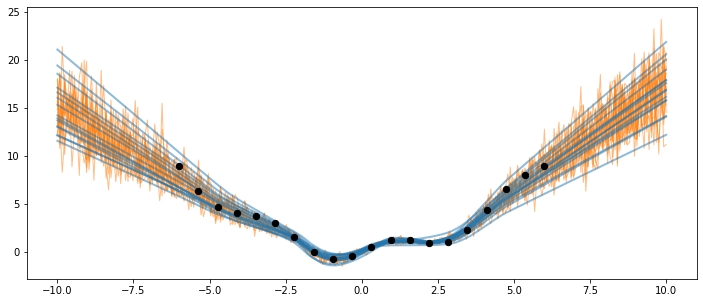

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.plot(X_domain[:, 0], samples_pe[:15, :, 0].numpy().T,
        c="C1", lw=1, alpha=0.5)

ax.plot(X_domain[:, 0], samples_sf[:15, :, 0].numpy().T,
        c="C0", lw=2, alpha=0.5)

ax.scatter(X_train, y_train, c="black", s=40,
           label="train", zorder=+10);

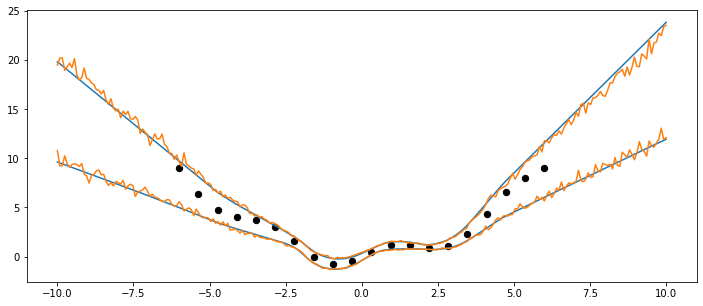

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

ax.scatter(X_train, y_train, c="black", s=40, label="train")

mean, std = samples_sf.mean(dim=0).numpy(), samples_sf.std(dim=0).numpy()
ax.plot(X_domain, mean + 1.96 * std, c="C0")
ax.plot(X_domain, mean - 1.96 * std, c="C0");

mean, std = samples_pe.mean(dim=0).numpy(), samples_pe.std(dim=0).numpy()
ax.plot(X_domain, mean + 1.96 * std, c="C1")
ax.plot(X_domain, mean - 1.96 * std, c="C1");

#### Question(s) (to ponder in your spare time)

* what happens when you increase the number of samples path-wise and pointwise,
  and inspect their statistics?

<br>

## A brief reminder on Bayesian and Variational Inference

Bayesian Inference is a principled framework of reasoning about uncertainty.

In Bayesian Inference (**BI**) we *assume* that the observation
data $D$ follows a *model* $m$ with data generating distribution
$p(D\mid m, \omega)$ *governed by unknown parameters* $\omega$.
The goal of **BI** is to reason about the model and/or its parameters,
and new data given the observed data $D$ and our assumptions, i.e
to seek the **posterior** parameter and predictive distributions:

$$\begin{align}
    p(d \mid D, m)
        % &= \mathbb{E}_{
        %     \omega \sim p(\omega \mid D, m)
        % } p(d \mid D, \omega, m)
        &= \int p(d \mid D, \omega, m) p(\omega \mid D, m) d\omega
    \,, \\
    p(\omega \mid D, m)
        &= \frac{p(D\mid \omega, m) \, \pi(\omega \mid m)}{p(D\mid m)}
    \,.
\end{align}
$$

* the **prior** distribution $\pi(\omega \mid m)$ reflects our belief
  before having made the observations

* the data distribution $p(D \mid \omega, m)$ reflects our assumptions
  about the data generating process, and determines the parameter
  **likelihood** (Gaussian, Categorical, Poisson)

Unless the distributions and likelihoods are conjugate, posterior in
Bayesian inference is typically intractable and it is common to resort
to **Variational Inference** or **Monte Carlo** approximations.

This key idea of this approach is to seek an approximation $q(\omega)$
to the intractable posterior $p(\omega \mid D, m)$, via a variational
optimization problem over some tractable family of distributions $\mathcal{Q}$:

$$
    q^*(\omega)
        \in \arg \min_{q\in \mathcal{Q}} \mathrm{KL}(q(\omega) \| p(\omega \mid D, m))
    \,, $$

where the Kullback-Leibler divergence between $P$ and $Q$ ($P\ll Q$)
with densities $p$ and $q$, respectively, is given by

$$
    \mathrm{KL}(q(\omega) \| p(\omega))
%         = \mathbb{E}_{\omega \sim Q} \log \tfrac{dQ}{dP}(\omega)
        = \mathbb{E}_{\omega \sim q(\omega)}
            \log \tfrac{q(\omega)}{p(\omega)}
    \,. \tag{kl-div} $$


Note that the family of variational approximations $\mathcal{Q}$ can be
structured **arbitrarily**: point-mass, products, mixture, dependent on
input, having mixed hierarchical structure, -- any valid distribution.

Although computing the divergence w.r.t. the unknown posterior
is still hard and intractable, it is possible to do away with it
through the following identity, which is based on the Bayes rule.

For **any** $q(\omega) \ll p(\omega \mid D; \phi)$ and any model $m$

$$
    \overbrace{
        \log p(D \mid m)
    }^{\text{evidence}}
        = \underbrace{
            \mathbb{E}_{\omega \sim q} \log p(D\mid \omega, m)
        }_{\text{expected conditional likelihood}}
        - \overbrace{
            \mathrm{KL}(q(\omega)\| \pi(\omega \mid m))
        }^{\text{proximity to prior belief}}
        + \underbrace{
            \mathrm{KL}(q(\omega)\| p(\omega \mid D, m))
        }_{\text{posterior approximation}}
    \,. \tag{master-identity} $$

Therefore, we can solve an equivalent maximization problem with respect to $q(\omega)$:

$$
    q^* \in
    \arg\max_{q\in Q}
        \mathrm{ELBO}(q) = 
            \mathbb{E}_{\omega \sim q} \log p(D\mid \omega, m)
            - \mathrm{KL}(q(\omega)\| \pi(\omega \mid m))
    \,. $$

* the expected likelihood -- favours $q$ that place their mass on
parameters $\omega$ that explain the observed data under the specified
model $m$.

* the negative KL-divergence -- encourages variational densities
not to stray away too far from to the prior belief under the model $m$.

If the assumed likelihood $p(D \mid \omega, m)$ and the prior $\pi(\omega\mid m)$
have their own parameters $\phi$, then the lower bound

$$
    \log p_\phi(D \mid m)
        \geq \mathrm{ELBO}(q, \phi)
            = \mathbb{E}_{\omega \sim q(\omega)} \log p_\phi(D \mid \omega, m)
            - \mathbb{E}_{\omega \sim q(\omega)} \log \frac{q(\omega)}{\pi_\phi(\omega)}
    \,, $$

naturaly yields a coordinate-wise ascent algorithm:
* **(E)** step wrt $q$, fixed $\phi$
* **(M)** step wrt $\phi$, fixed $q$

Typically the variational approximation yields high dimensional
integrals, that are computationally heavy. To make the computations
faster without foregoing much of precision, we may use sampling,
or Monte Carlo methods. For the predictive distribution, for example,
we have

$$
\begin{align}
    \mathbb{E}_{y\sim p(y\mid x, D, m)} \, g(y)
        &\overset{\text{BI}}{=}
            \mathbb{E}_{\omega\sim p(\omega \mid D, m)}
                \mathbb{E}_{y\sim p(y\mid x, \omega, D, m)} \, g(y) 
        \\
        &\overset{\text{VI}}{\approx}
            \mathbb{E}_{\omega\sim q(\omega)}
                \mathbb{E}_{y\sim p(y\mid x, \omega, D, m)} \, g(y)
        \\
        &\overset{\text{MC}}{\approx}
%             \hat{\mathbb{E}}_{\omega \sim \mathcal{W}}
%                 \mathbb{E}_{y\sim p(y\mid x, \omega, D, m)} \, g(y)
            \frac1{\lvert \mathcal{W}\rvert} \sum_{\omega \in \mathcal{W}}
                \mathbb{E}_{y\sim p(y\mid x, \omega, D, m)} \, g(y)
    \,,
\end{align}
$$

where $\mathcal{W} = (\omega_b)_{b=1}^B \sim q(\omega)$
-- iid samples from the variational approximation.

**(note)** If $p(y \mid x, \omega, D, m)$ yiled "heavy" integrals then
we apply Monte Carlo to it too.

A good summary of Bayesian Inference can be found in [this lecture](http://mlg.eng.cam.ac.uk/zoubin/talks/lect1bayes.pdf), [this paper](https://arxiv.org/abs/1206.7051.pdf), [this review](https://arxiv.org/abs/1601.00670.pdf).
It is also posbile to consult [wiki](https://en.wikipedia.org/wiki/Bayesian_inference) and references therein.

<br>

## Bayesian Active Learning with images

* Data labelling is costly and time consuming
* unlabeled instances are essentially free

**Goal** Achieve high performance with fewer labels by
identifying the best instances to learn from

Essential blocks of active learning:

* a **model** $m$ capable of quantifying uncertainty (preferably bayesian model)
* an **acquisition function** $a\colon \mathcal{M} \times \mathcal{X}^* \to \mathbb{R}$
  that for any finite set of inputs $S\subset \mathcal{X}$ quantifies their usefulness
  to the model $m\in \mathcal{M}$
* a labelling **oracle**, e.g. a human expert

The main loop of active learning:

1. fit $m$ on $\mathcal{S}_{\mathrm{labelled}}$

2. get exact or approximate $$
    \mathcal{S}^* \in \arg \max\limits_{S \subseteq \mathcal{S}_\mathrm{unlabelled}}
        a(m, S)
$$ **without** access to targets and satisfying **budget constraints**, i.e.
$\lvert S \rvert \leq \ell$ or other economically motivated constraints.

3. request the **oracle** to provide labels for each $x\in \mathcal{S}^*$

4. update $
\mathcal{S}_{\mathrm{labelled}}
    \leftarrow \mathcal{S}^*
        \cup \mathcal{S}_{\mathrm{labelled}}
$ and goto 1.

We already have a Bayesian model that can be used to reason
about uncertainty, so let's focus on the acquisition function.

### the Acquisition Function

There are many acquisition criteria (borrowed from [Gal17a](http://proceedings.mlr.press/v70/gal17a.html)):
* Classification
  * Max entropy (plain uncertainty)
  * Maximal information about parameters and predictions (mutual information)
  * Variance ratios
  * Mean standard deviation
  * **BALD**
* Regression
  * predictive variance

**BALD** (Bayesian Active Learning by Disagreement) acquisition
criterion is based on the posterior mutual information between model's
predictions $y_x$ at some point $x$ and model's parameters $\omega$:

$$\begin{align}
    a(m, S)
        &= \sum_{x\in S} a(m, \{x\})
        \\
    a(m, \{x\})
        &= \mathbb{I}(y_x; \omega \mid x, m, D)
\end{align}
    \,, \tag{bald} $$

with the [**Mutual Information**](https://en.wikipedia.org/wiki/Mutual_information#Relation_to_Kullback%E2%80%93Leibler_divergence)
(**MI**)
$$
    \mathbb{I}(y_x; \omega \mid x, m, D)
        = \mathbb{H}\bigl(
            \mathbb{E}_{\omega \sim q(\omega\mid m, D)}
                p(y_x \,\mid\, x, \omega, m, D)
        \bigr)
        - \mathbb{E}_{\omega \sim q(\omega\mid m, D)}
            \mathbb{H}\bigl(
                p(y_x \,\mid\, x, \omega, m, D)
            \bigr)
    \,, \tag{mi} $$

and the [(differential) **entropy**](https://en.wikipedia.org/wiki/Differential_entropy#Differential_entropies_for_various_distributions)
(all densities and/or probability mass functions can be conditional):

$$
    \mathbb{H}(p(y))
        = - \mathbb{E}_{y\sim p} \log p(y)
    \,. $$

Instead of the exact formula for **MI** we shall use its **Monte Carlo** (**MC**)
approximation, since the expectations are analytically or numerically
tractable only in simple low dimensional cases.
<!-- probability integrals are still integrals -->

Consider an iid sample $\mathcal{W} = (\omega_b)_{b=1}^B \sim q(\omega \mid m, D)$
of size $B$. The **MC** approximation of the mutual information is

$$
    \mathbb{I}_\mathrm{MC}(y_x; \omega \mid x, m, D)
        = \mathbb{H}\bigl(
            \hat{\mathbb{E}}_{\omega \sim \mathcal{W}}
                p(y_x \,\mid\, x, \omega, m, D)
        \bigr)
        - \hat{\mathbb{E}}_{\omega \sim \mathcal{W}}
            \mathbb{H}\bigl(
                p(y_x \,\mid\, x, \omega, m, D)
            \bigr)
    \,, \tag{mi-mc} $$

where $\hat{\mathbb{E}}_{\omega \sim \mathcal{W}} h(\omega) = \tfrac1B \sum_j h(\omega_j)$
denotes the expectation with respect to the empirical probability measure induced
by the sample $\mathcal{W}$.

<br>

#### (task) implementing entropy

For categorical (discrete) random variables $y \sim \mathcal{Cat}(\mathbf{p})$,
$\mathbf{p} \in \{ \mu \in [0, 1]^d \colon \sum_k \mu_k = 1\}$, the entropy is

$$
    \mathbb{H}(p(y))
        = - \mathbb{E}_{y\sim p(y)} \log p(y)
        = - \sum_k p_k \log p_k
    \,. $$

**(note)** although in calculus $0 \cdot \log 0 = 0$ (because
$\lim_{p\downarrow 0} p \cdot \log p = 0$), in floating point
arithmetic $0 \cdot \log 0 = \mathrm{NaN}$. So you need to add
some really tiny float to the argument of $\log$.

In [29]:
def entropy(proba):
    """Compute the entropy along the last dimension."""

    ## Exercise: get the entropy of a tensor with distributions
    #  along the last axis.

    pass

<br>

#### (task) implementing mutual information

Consider a tensor $p_{bik}$ of probabilities $p(y_{x_i}=k \mid x_i, \omega_b, m, D)$
with $\omega_b \sim q(\omega \mid m, D)$.

Let's implement a procedure that computes the **MC** estimate 
of the posterior predictive distribution

$$
\hat{p}(y_x\mid x, m, D)
    = \hat{\mathbb{E}}_{\omega \sim \mathcal{W}}
        \,p(y_x \mid x, \omega, m, D)
    \,, $$

its **entropy** $
    \mathbb{H}\bigl(\hat{p}(y\mid x, m, D)\bigr)
$ and **mutual information** $
    \mathbb{I}_\mathrm{MC}(y_x ; \omega\mid x, m, D)
$

In [30]:
def mutual_information(proba):
    ## Exercise: compute a monte carlo estimator of the predictive
    ##   distribution, its entropy and MI `H E_w p(., w) - E_w H p(., w)`

    proba_avg = 

    entropy_expected = 
    expected_entropy = 

    mut_info = 

    pass

    return proba_avg, entropy_expected, mut_info

<br>

#### (task) implementing BALD acqustion

The acquisition function that we will implement takes in the
sample mutual information and returns the indices of selected
points.



Note that $a(m, S)$ is additively separable, i.e. equals $\sum_{x\in S} a(m, \{x\})$.
This implies that

$$
\begin{align}
    \max_{S \subseteq \mathcal{S}_\mathrm{unlabelled}} a(m, S)
        &= \max_{z \in \mathcal{S}_\mathrm{unlabelled}}
            \max_{F \in \mathcal{S}_\mathrm{unlabelled} \setminus \{z\}}
            \sum_{x\in F \cup \{x\}} a(m, \{x\})
        \\
        &= \max_{z \in \mathcal{S}_\mathrm{unlabelled}}
            a(m, \{z\})
            + \max_{F \in \mathcal{S}_\mathrm{unlabelled} \setminus \{z\}}
                \sum_{x\in F} a(m, \{x\})
\end{align}
    \,. $$

Therefore selecting the $\ell$ `most interesting` points from $\mathcal{S}_\mathrm{unlabelled}$
is trivial.


In [31]:
def acq_bald(mutual_info, n_points=10):
    ## Exercise: implement the acquisition

    return indices

    pass

<br>

**(note)** A drawback of the `pointwise` top-$\ell$ procedure above is
that, although it acquires individually informative instances, altogether
they might end up **being** `jointly poorly informative`. This can be
corrected if we would seek the highest mutual information among finite
sets $S \subseteq \mathcal{S}_\mathrm{unlabelled}$ of size $\ell$.
Such acquisiton funciton is called **batch-BALD**
([Kirsch et al.; 2019](https://arxiv.org/abs/1906.08158.pdf)):

$$\begin{align}
    a(m, S)
        &= \mathbb{I}\bigl((y_x)_{x\in S}; \omega \mid S, m \bigr)
        = \mathbb{H} \bigl(
            \mathbb{E}_{\omega \sim q(\omega\mid m)} p\bigl((y_x)_{x\in S}\mid S, \omega, m \bigr)
        \bigr)
        - \mathbb{E}_{\omega \sim q(\omega\mid m)} H\bigl(
            p\bigl((y_x)_{x\in S}\mid S, \omega, m \bigr)
        \bigr)
\end{align}
    \,. \tag{batch-bald} $$

This criterion requires exponentially large number of computations and
memory, however there are working solutions like random sampling of subsets
$\mathcal{S}$ of size $\ell$ from $\mathcal{S}_\mathrm{unlabelled}$ or
greedy maximization of this *submodular* criterion.

> Kirsch, A., van Amersfoort, J., & Gal, Y. (2019). BatchBALD: Efficient and Diverse Batch Acquisition for Deep Bayesian Active Learning. arXiv preprint [arXiv:1906.08158](https://arxiv.org/abs/1906.08158.pdf)

<br>

#### (task*) Unbiased estimator of entropy and mutual informaiton

The first term in the **MC** estimate of the mutual information is the
so-called **plug-in** estimator of the entropy:

$$
    \hat{H}
        = \mathbb{H}(\hat{p}) = - \sum_k \hat{p}_k \log \hat{p}_k
    \,, $$

where $\hat{p}_k = \tfrac1B \sum_b p_{bk}$ is the full sample estimator
of the probabilities.

It is known that this plug-in estimate is biased
(see [blog: Nowozin, 2015](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-1.html)
and references therein, also this [notebook](https://colab.research.google.com/drive/1z9ZDNM6NFmuFnU28d8UO0Qymbd2LiNJW)). <!--($\log$ + Jensen)-->
In order to correct for small-sample bias we can use
[jackknife resampling](https://en.wikipedia.org/wiki/Jackknife_resampling).
It derives an estimate of the finite sample bias from the leave-one-out
estimators of the entropy and is relatively computationally cheap
(see [blog: Nowozin, 2015](http://www.nowozin.net/sebastian/blog/estimating-discrete-entropy-part-2.html),
[Miller, R. G. (1974)](http://www.math.ntu.edu.tw/~hchen/teaching/LargeSample/references/Miller74jackknife.pdf) and these [notes](http://people.bu.edu/aimcinto/jackknife.pdf)).

The jackknife correction of a plug-in estimator $\mathbb{H}(\cdot)$
is computed thus: given a sample $(p_b)_{b=1}^B$ with $p_b$ -- discrete distribution on $1..K$
* for each $b=1.. B$
  * get the leave-one-out estimator: $\hat{p}_k^{-b} = \tfrac1{B-1} \sum_{j\neq b} p_{jk}$
  * compute the plug-in entropy estimator: $\hat{H}_{-b} = \mathbb{H}(\hat{p}^{-b})$
* then compute the bias-corrected entropy estimator $
\hat{H}_J
    = \hat{H} + (B - 1) \bigl\{
        \hat{H} - \tfrac1B \sum_b \hat{H}^{-b}
    \bigr\}
$

**(note)** when we knock the $i$-th data point out of the sample mean
$\mu = \tfrac1n \sum_i x_i$ and recompute the mean $\mu_{-i}$ we get
the following relation
$$ \mu_{-i}
    = \frac1{n-1} \sum_{j\neq i} x_j
    = \frac{n}{n-1} \mu - \tfrac1{n-1} x_i
    = \mu + \frac{\mu - x_i}{n-1}
    \,. $$
This makes it possible to quickly compute leave-one-out estimators of
discrete probability distribution.

In [32]:
if False:  # if you solved this, dont forget to remove the guard
    def mutual_information(proba):
        ## Exercise: MC estimate of the predictive distribution, entropy and MI
        ##  mutual information `H E_w p(., w) - E_w H p(., w)` with jackknife
        ##  correction.

        return proba_avg, entropy_expected, mut_info

<br>

### Dropout $2$-d Convolutional layer and the model

Typically, in convolutional neural networks the dropout acts upon the feature
(channel) information and not on the spatial dimensions. Thus entire channels
are dropped out and for $
    x \in \mathbb{R}^{
        [\mathrm{in}]
        \times h
        \times w}
$ and $
    y \in \mathbb{R}^{
        [\mathrm{out}]
        \times h'
        \times w'}
$ the full effect of the `Dropout+Conv2d` layer is

$$
    y_{lij} = ((x \odot m) \ast W_l)_{ij} + b_l
        = b_l + \sum_k \sum_{pq} x_{k i_p j_q} m_k W_{lkpq}
    \,, \tag{conv-2d} $$
    
where i.i.d $m_k \sim \mathcal{Ber}\bigl(\bigl\{0, \tfrac1{1-p}\bigr\}, 1-p\bigr)$,
and indices $i_p$ and $j_q$ represent the spatial location in $x$ that correspond
to the $p$ and $q$ elements in the kernel $
    W\in \mathbb{R}^{
        [\mathrm{out}]
        \times [\mathrm{in}]
        \times h
        \times w}
$ relative to $(i, j)$ coordinates in $y$.
The exact values of $i_p$ and $j_q$ depend on the configuration of the
convolutional layer, e.g. stride, kernel size and dilation.

<br>

#### (task) Implementing sampling

For images we don't usually use the `F.dropout` form our previous
experiments, because when applied to the data $
x \in \mathbb{R}^{
    [\mathrm{in}]
    \times h
    \times w
}
$ it would affect random pixels within each input feature: 

$$
\mathrm{F.dropout}(x)
    \colon x \mapsto x \odot m
    = \bigl( x_{kij} \, m_{kij} \bigr)_{kij}
    \,. $$

Please use `F.dropout2d` instead. You would also need to invoke `F.conv2d`.

In [33]:
class DropoutConv2d(torch.nn.Conv2d, VariationalModule):
    """2d Convolutional layer with dropout on input features."""
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros',
                 p=0.5):

        super().__init__(in_channels, out_channels, kernel_size, stride=stride,
                         padding=padding, dilation=dilation, groups=groups,
                         bias=bias, padding_mode=padding_mode)

        self.p = p

    def forward(self, input):        
        """Apply feature dropout and then forward pass through the convolution."""
    
        # Exercise: take a look at "Conv2d.forward??" in a new cell. It will
        #  help you understand what to pass to `F.conv2d`. For cleaner code
        #  use a super-method.

        pass

    def sample(self):
        """Sample the weight from the parameter distribution."""

        ## Exercise: dropout input filter in the convolutional kernel

        pass

        if self.bias is not None:
            return {"weight": weight, "bias": self.bias}
        return {"weight": weight}

**(note)** For more on convolutions see
[Convolution arithmetic](https://github.com/vdumoulin/conv_arithmetic) 
repo.

<br>

Much like the `SimpleModel` class above in $1$d section,
let's implement a simple deep convolutional network.

In [34]:
class CNNModel(torch.nn.Module):
    """A simple convolutional net."""
    def __init__(self, m_conv2d, m_linear, **kwargs):
        assert issubclass(m_linear, torch.nn.Linear)
        assert issubclass(m_conv2d, torch.nn.Conv2d)
        super().__init__()

        self.conv_block = torch.nn.Sequential(
            Conv2d(1, 20, 5, 1),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(2),

            m_conv2d(20, 50, 5, 1, **kwargs),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(2)
        )

        self.fc1 = m_linear(4 * 4 * 50, 400, **kwargs)
        self.out = m_linear(400, 10, **kwargs)

    def forward(self, input):
        """Take images and compute their class logits."""
        x = self.conv_block(input).flatten(1)
        return self.out(F.relu(self.fc1(x)))

    def deterministic(self):
        """Return a deterministic version of self."""
        return type(self)(Conv2d, Linear)

To fit the classifier that outputs raw logit scores, we typically
normalize outputs via `F.log_softmax` and then feed into them into
`F.nll_loss`, which comuptes the negative $\log$-likelihood of a
categorical distribution.

However, this is less numerically stable then using `F.cross_entropy`,
which is essentially` log_softmax + nll` fused into one stable operation.
It is good practice to pay attention to numerical stability, especially
when working with `float32`.

In [35]:
def cross_entropy(model, X, y):
    return F.cross_entropy(model(X), y)  # + coef * sum(penalties(model))

<br>

### Actively Learning MNIST

We will partially replicate figure 1. in [Gat et al. (2017): p. 4](http://proceedings.mlr.press/v70/gal17a.html),

> Gal, Y., Islam, R. & Ghahramani, Z.. (2017). Deep Bayesian Active Learning with Image Data. Proceedings of the 34th International Conference on Machine Learning, in [PMLR 70:1183-1192](http://proceedings.mlr.press/v70/gal17a.html)


Prepare the datasets from the `train` part of [MNIST](http://yann.lecun.com/exdb/mnist/):
* ($\mathcal{S}_\mathrm{train}$) initial **training**:
  **empty** -- learn from scratch
  <strike>21 images, purposefully highly imbalanced classes (even absent ones)</strike>
* ($\mathcal{S}_\mathrm{valid}$) our **validation**:
  $5000$ images, stratified
* ($\mathcal{S}_\mathrm{pool}$) acquisition **pool**:
  all remaining images

The true test sample of MNIST is in $\mathcal{S}_\mathrm{test}$ -- we
will use it to evaluate the final performance.

In [36]:
from mlss2019bdl.dataset import get_dataset

S_train, S_pool, S_valid, S_test = get_dataset(
    n_train=0, n_valid=5000, name="MNIST",
    random_state=722_257_201, path="./data")

**(note)** We may just as well use [Kuzushiji-MNIST](https://github.com/rois-codh/kmnist)

Now, a function to plot images in a small dataset. 

In [37]:
from mlss2019bdl.flex import plot

def display(dataset, title=None, show_balance=True, figsize=None):
    images, targets = dataset.tensors
    if not show_balance:
        balance = ""

    else:
        body = [f"{n:2d}" if n > 0 else " *"
                for n in label_counts(targets)]
        balance = "(freq) [ " + ' '.join(body) + " ]"

    # a canvas
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # show the images
    plot(ax, images, cmap=plt.cm.bone)

    # produce a title
    title = "" if title is None else title
    title = title + (" " if title else "")
    ax.set_title(f"{title}{balance}")

    plt.show()
    plt.close()


def label_counts(labels, n_labels=10):
    return np.bincount(labels.numpy(), minlength=10)

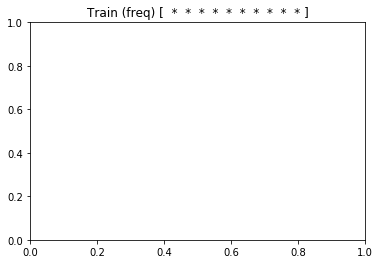

In [38]:
display(S_train, title="Train")

<br>

#### Necessary components for the loop

We need to be able to manipulate the datasets for the **main active learning**
loop. We begin by implementing the following primitives:
* `take` collect the instances at the specified indices into a **new dataset** (object)
* `append` add one dataset to another
* `delete` drops the instances at the specified locations form the copy of the **dataset**

In [39]:
from mlss2019bdl.dataset import take, delete, append

For the **main active learning** loop, besides manipulating the datasets,
we shall also need a function to **predict and acquire** and evaluate
holdout **performance**.


In [40]:
def predict(model, dataset, n_samples=1):
    logits = sample_function(model, dataset, n_samples=n_samples)

    # logit-scores should be transformed into a proper distribution
    return F.softmax(logits, dim=-1)

In [41]:
def acquire(model, dataset, n_points=10, n_samples=1):
    proba = predict(model, dataset, n_samples=n_samples)

    _, _, mutual_info = mutual_information(proba)

    return acq_bald(mutual_info, n_points)

In [42]:
def evaluate(model, dataset, n_samples=1):
    proba = predict(model, dataset, n_samples=n_samples)
    
    proba_avg = proba.mean(dim=0)

    predicted = proba_avg.argmax(dim=-1).numpy()
    target = dataset.tensors[1].cpu().numpy()

    return confusion_matrix(target, predicted)

<br>

#### (task) Implmenting the active learning step

Let's code the core of the active learning loop:

1. fit on **train**, then (optional) evaluate on **holdout**
2. acquire from **pool**
3. add to **train** (removing from **pool**)


In [43]:
def active_learning_step(model, S_train, S_pool,
                         n_epochs=5, n_points=10, n_samples=11):
    ## Exercise: implement the fit-acquire loop

    # 1. fit on S_train using `cross_entropy`, set `weight_decay` to 1e-4
    fit()

    # 2. acquire new instances from S_pool
    indices = acquire()

    # 3. query the pool for the chosen instances, then take-append-delete
    S_requested = ...
    S_train = ...
    S_pool = ...

    pass

    return model, S_train, S_pool, S_requested

<br>

In [44]:
model = CNNModel(DropoutConv2d, DropoutLinear, p=0.5)

model.to(device)

CNNModel(
  (conv_block): Sequential(
    (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): DropoutConv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): DropoutLinear(in_features=800, out_features=400, bias=True)
  (out): DropoutLinear(in_features=400, out_features=10, bias=True)
)

<br>

Now we Recall that it consists of the following steps

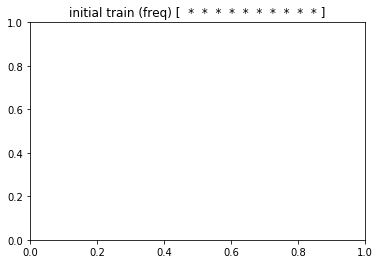

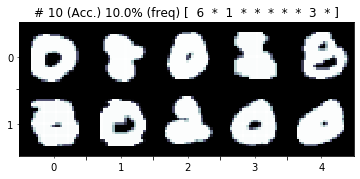

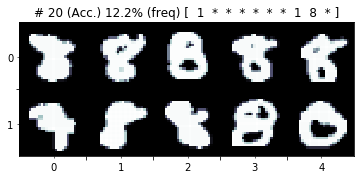

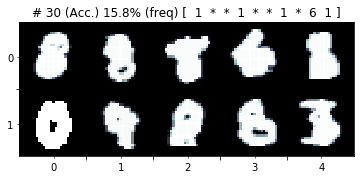

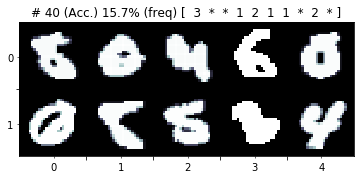

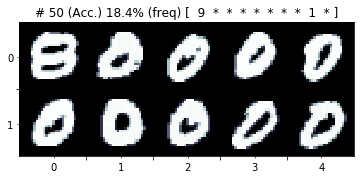

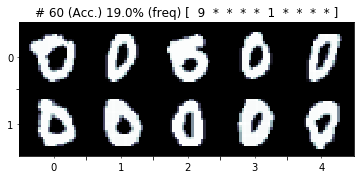

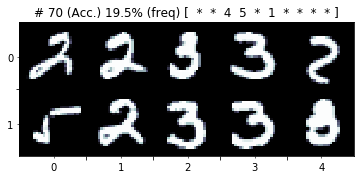

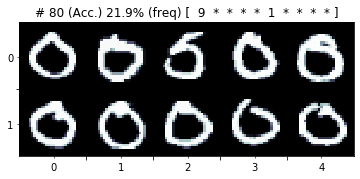

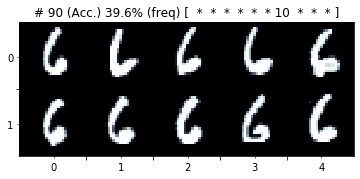

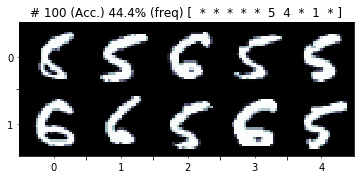

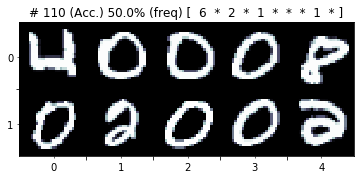

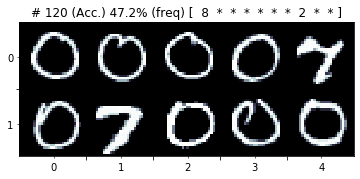

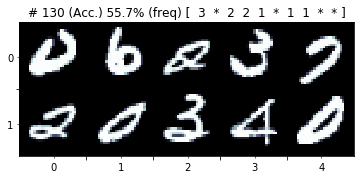

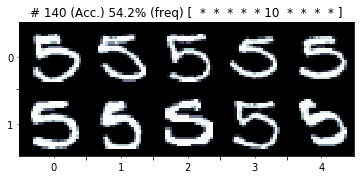

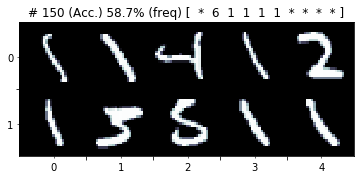

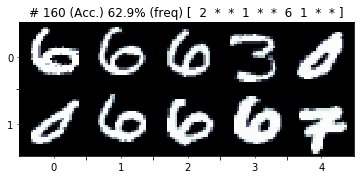

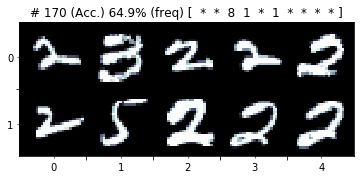

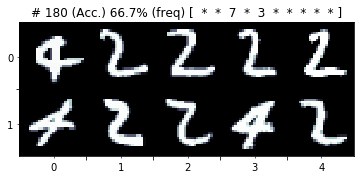

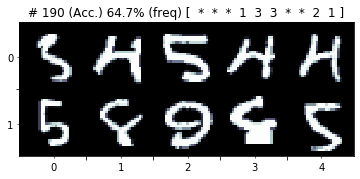

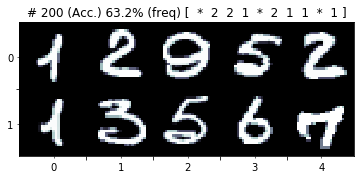

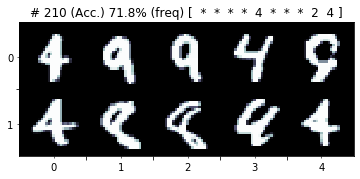

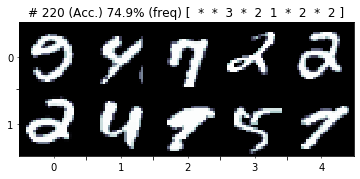

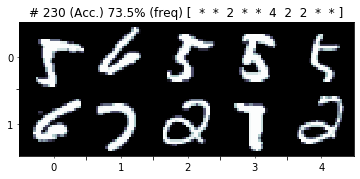

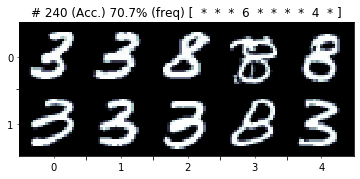

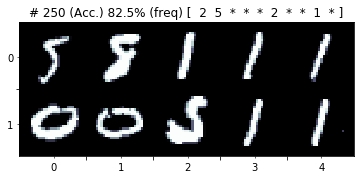

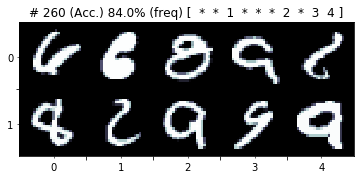

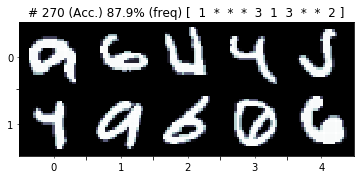

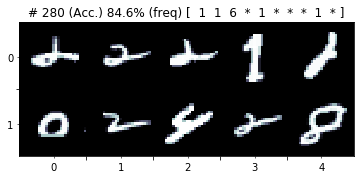

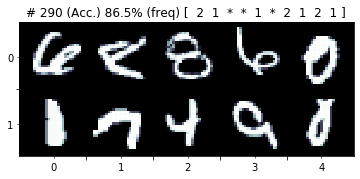

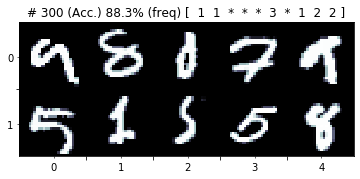

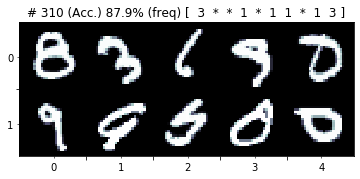

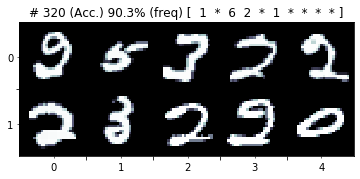

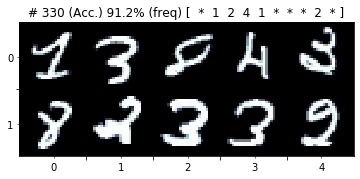

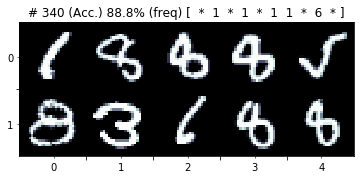

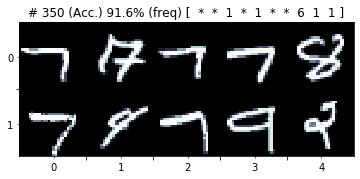

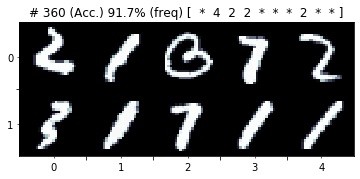

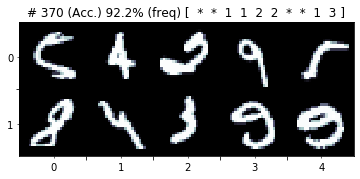

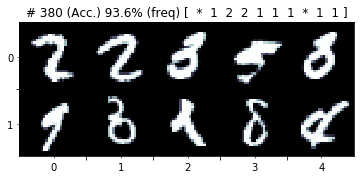

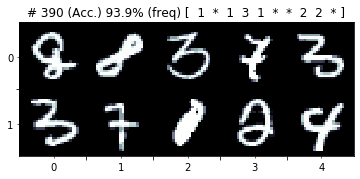

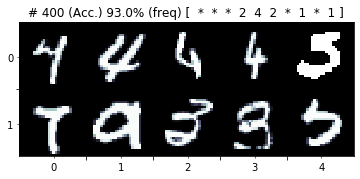

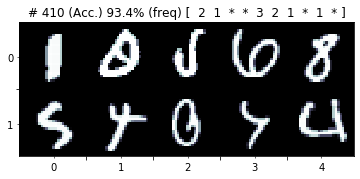

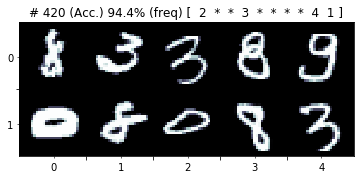

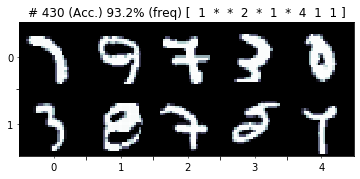

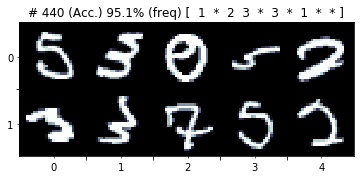

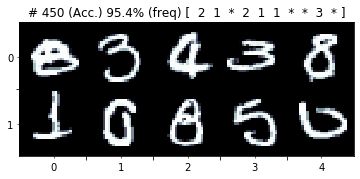

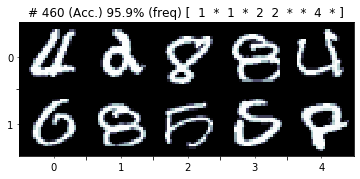

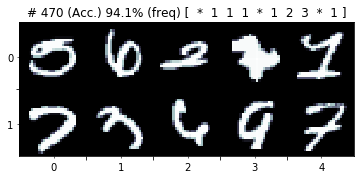

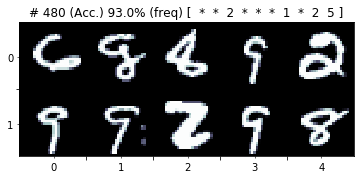

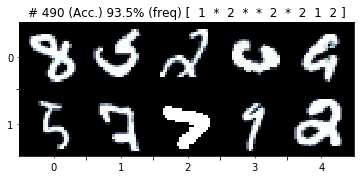

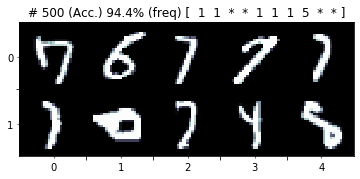

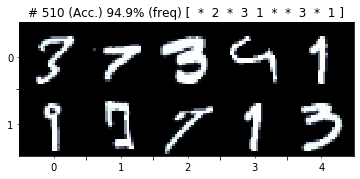

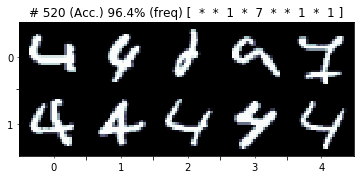

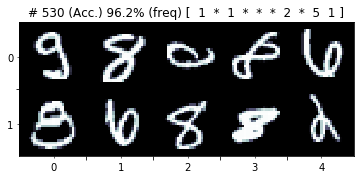

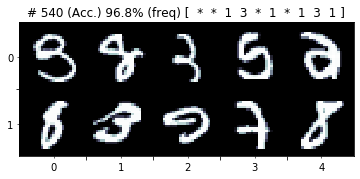

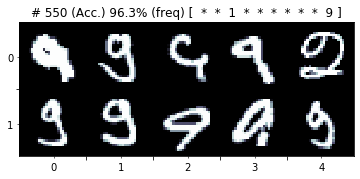

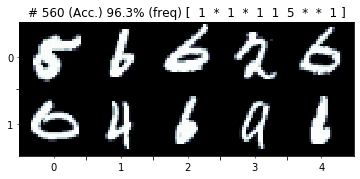

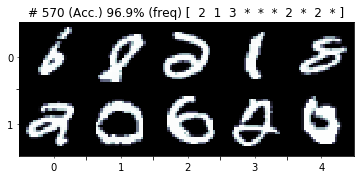

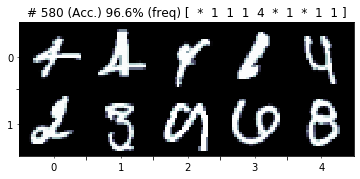

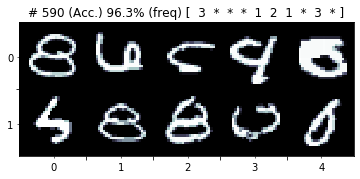

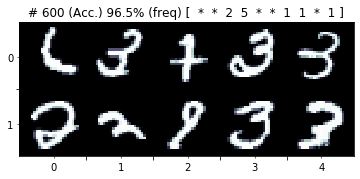

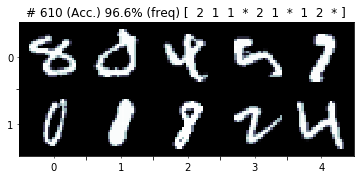

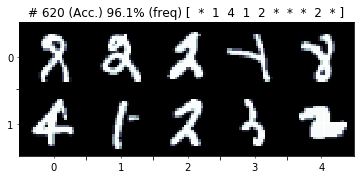

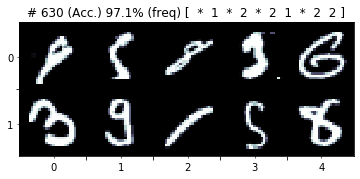

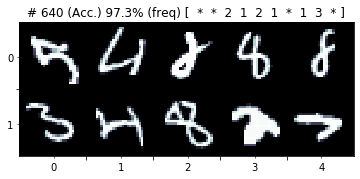

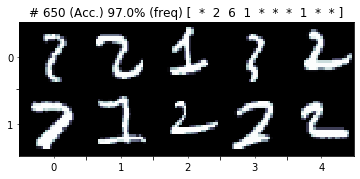

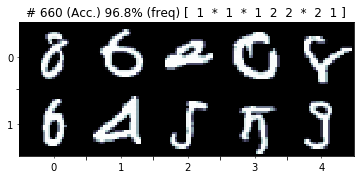

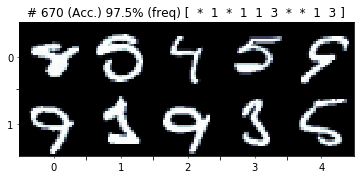

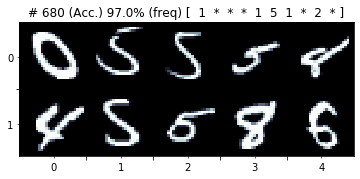

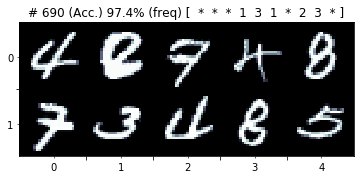

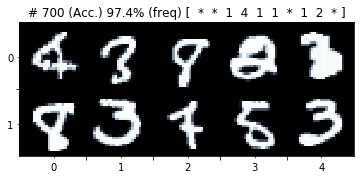

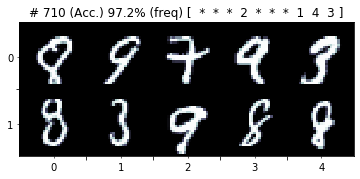

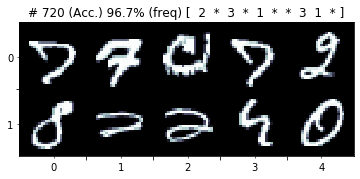

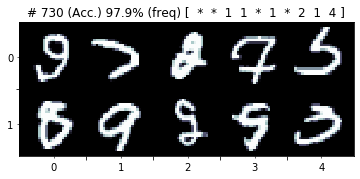

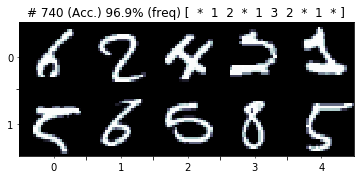

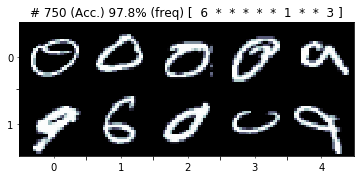

In [45]:
n_epochs, n_samples = 5, 11
n_active, n_points = 75, 10

display(S_train, title="initial train")

scores = []
balances = [label_counts(S_train.tensors[1])]
for step in range(n_active):
    model, S_train, S_pool, S_requested = active_learning_step(
        model, S_train, S_pool, n_epochs=n_epochs,
        n_points=n_points, n_samples=n_samples)

    # (optional) track validation score
    score_matrix = evaluate(model, S_valid, n_samples=n_samples)

    # (optional) report accuracy and the statistics on the acquired batch
    balances.append(label_counts(S_train.tensors[1]))
    scores.append(score_matrix)

    accuracy = score_matrix.diagonal().sum() / score_matrix.sum()
    display(S_requested, title=f"# {len(S_train)} (Acc.) {accuracy:.1%}")

Train of the final $\mathcal{S}_\mathrm{train}$ and evaluate the result

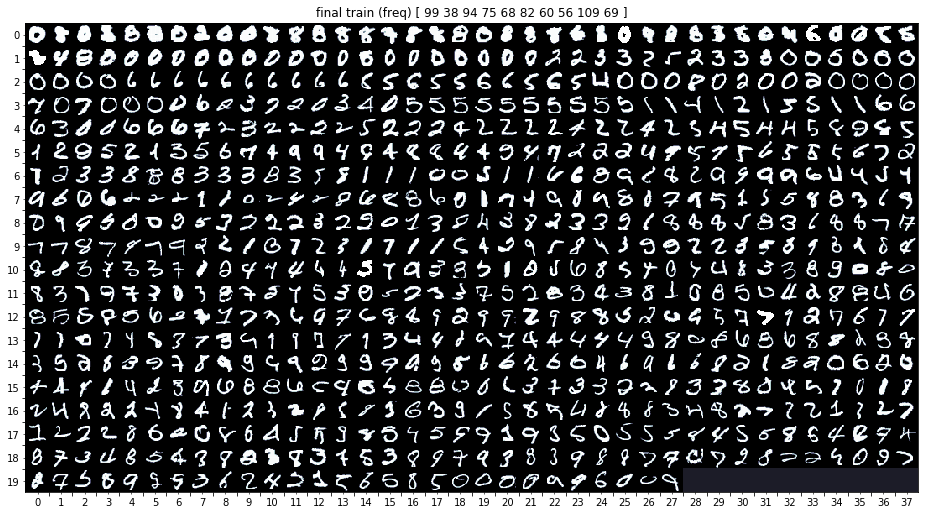

In [46]:
balances = np.stack(balances, axis=0)

fit(model, S_train, criterion=cross_entropy, n_epochs=n_epochs, weight_decay=1e-4)
scores.append(evaluate(model, S_valid, n_samples=n_samples))

scores = np.stack(scores, axis=0)

display(S_train, title="final train", figsize=(16, 9))

<br>

### Results

Let's see the dynamics of the frequency of each class in $\mathcal{S}_\mathrm{train}$

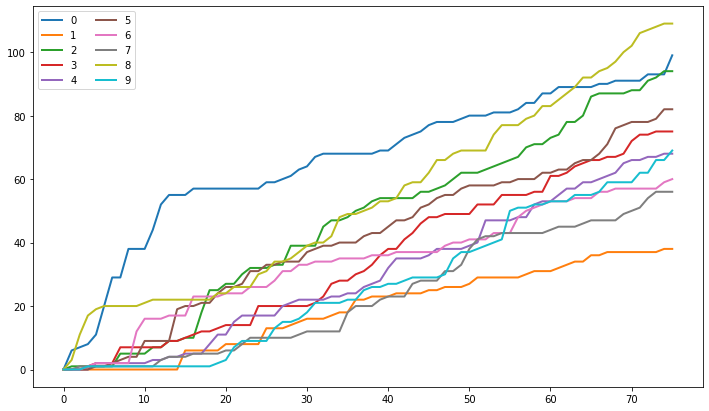

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lines = ax.plot(balances, lw=2)
plt.legend(lines, list(range(10)), ncol=2);

The dynamics of *one-versus-rest* precision / recall scores on
$\mathcal{S}_\mathrm{valid}$. For binary classification:

$$ \begin{align}
\mathrm{Precision}
    &= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FP}}
        \approx \mathbb{P}(y = 1 \mid \hat{y} = 1)
    \,, \\
\mathrm{Recall}
    &= \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}
        \approx \mathbb{P}(\hat{y} = 1 \mid y = 1)
    \,.
\end{align}$$

In [48]:
tp = scores.diagonal(axis1=-2, axis2=-1)
fp, fn = scores.sum(axis=-2) - tp, scores.sum(axis=-1) - tp

/home/ivan.nazarov/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


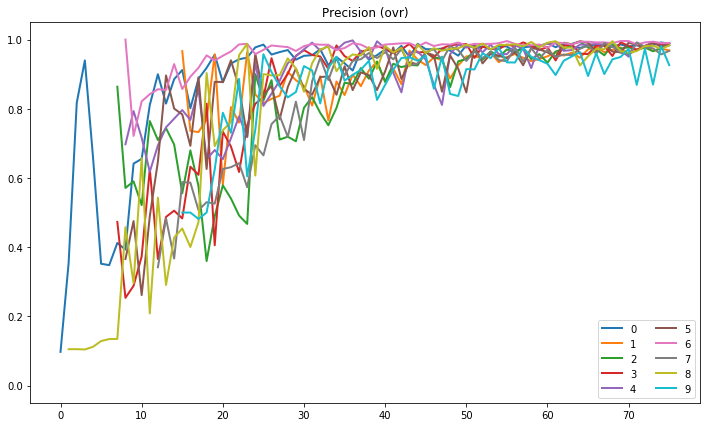

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lines = ax.plot(tp / (tp + fp), lw=2)
ax.set_title("Precision (ovr)")
ax.legend(lines, list(range(10)), ncol=2);

plt.show()

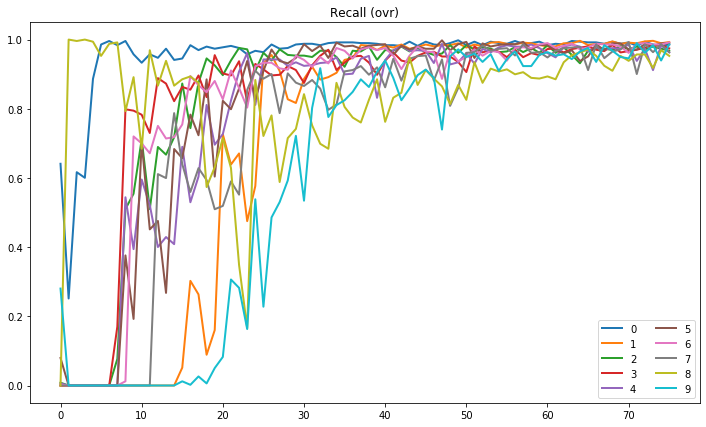

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

lines = ax.plot(tp / (tp + fn), lw=2)
ax.set_title("Recall (ovr)")
ax.legend(lines, list(range(10)), ncol=2)

plt.show()

The accuracy as a function of active learning iteration.

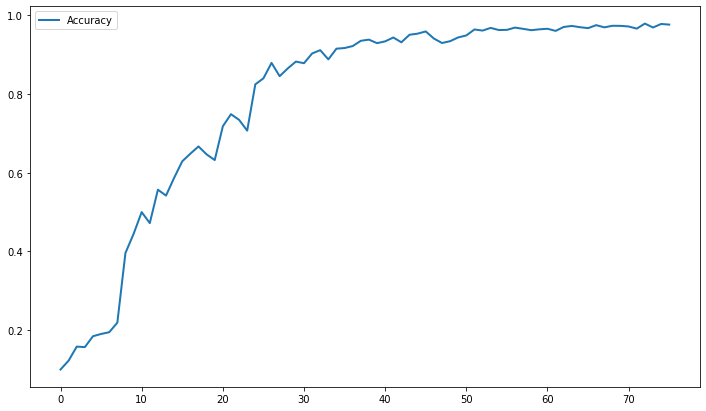

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

ax.plot(tp.sum(-1) / scores.sum((-2, -1)),
        label='Accuracy', lw=2)
ax.legend()

plt.show()

Volume of data used

In [52]:
f"train : pool = {len(S_train)} : {len(S_pool)}"

'train : pool = 750 : 54250'

Let the test set confusion matrix be the ultimate judge:

In [53]:
score_matrix = evaluate(model, S_test, n_samples=51)

True positives, and false positives / negatives

In [54]:
tp = score_matrix.diagonal(axis1=-2, axis2=-1)
fp, fn = score_matrix.sum(axis=-2) - tp, score_matrix.sum(axis=-1) - tp

accuracy

In [55]:
f"(accuracy) {tp.sum() / score_matrix.sum():.2%}"

'(accuracy) 97.82%'

one-v-rest precision

In [56]:
{l: f"{p:.2%}" for l, p in enumerate(tp / (tp + fp))}

{0: '97.99%',
 1: '97.41%',
 2: '98.51%',
 3: '99.40%',
 4: '98.76%',
 5: '97.25%',
 6: '99.47%',
 7: '96.94%',
 8: '97.56%',
 9: '95.11%'}

ovr recall

In [57]:
{l: f"{p:.2%}" for l, p in enumerate(tp / (tp + fn))}

{0: '99.49%',
 1: '99.47%',
 2: '96.32%',
 3: '98.12%',
 4: '97.25%',
 5: '99.10%',
 6: '98.12%',
 7: '95.43%',
 8: '98.67%',
 9: '96.33%'}